**NOTE**: The dataset link did not work for me and I could not find any datasets page on Canvas as I believe was referenced in the Microsoft Teams Q&A channel. I did however find a dataset at the following link with the same file names, columns, and approximate number of samples and that is what I used to complete this assignment. https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection 

In [1]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer

## LOAD DATASET
df_true = pd.read_csv("true.csv")
df_fake = pd.read_csv("fake.csv")

## PREPROCESSING
df_true['class'] = 0; df_fake['class'] = 1 
df = pd.concat([df_fake, df_true], ignore_index=True) 
n = len(df)

## CLEANING
unique_title = 100 * df["title"].nunique() / df.title.count()
print(f"Unique Titles: {unique_title:.2f}%")

## DROP TITLE DUPLICATES
df = df.drop_duplicates('title')
print(f"Dropped {n-len(df)} title duplicates")
n = len(df)

## CHECK CLASS BALANCE AFTER REDUCING DATASET
df.reset_index(inplace=True)
class_balance = 100 * df["class"].sum() / df["class"].count()
print(f"Class balance: {class_balance:.2f}% Fake Samples")

## COMPUTE FEATURES AND TARGETS
X = TfidfVectorizer(stop_words='english', max_features=50).fit_transform(df['title'])
y = df["class"]

Unique Titles: 86.26%
Dropped 6169 title duplicates
Class balance: 46.23% Fake Samples


1. [70 pts] By using three classifiers—decision tree, random forest, and neural network—and at least 2 different hyperparameter settings for each, generate operating points and plot them on a ROC. In particular, plot mean TPR and mean FPR, where the means are taken from the multiple runs of cross-validations. Do not hesitate to use/modify the ROC plot code in the module notebook if necessary. In case you do not see enough variety in Pd-Pf you might need to work on the classifiers set and/or hyperparameters. And do not hesitate to try hundreds, if necessary, since the ROC is just a natural scatter plot. (Some recommended parameters and ranges: depth [3-12], number of features [3-20], number of estimators [20-100], layer size [1-10], learning rate; and total of 10-20 Ops.)  

In [19]:

## PROBLEM 1
import numpy as np 
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt; 
from tqdm import trange


def train(model, X, y, k=10):
    ## K-FOLD CROSS VALIDATION
    acc, tpr, fpr = [], [], []
    kfold = KFold(n_splits=k,shuffle=False)
    for i_train, i_test in kfold.split(X, y):
        
        ## TRAIN MODEL
        model.fit(X[i_train], y[i_train])
        y_pred = model.predict(X[i_test])

        ## COMPUTE METRICS
        conf = metrics.confusion_matrix(y[i_test], y_pred)
        tpr.append(conf[0,0] / (conf[0,0] + conf[1,0] + 1e-10))
        fpr.append(conf[0,1] / (conf[0,0] + conf[0,1] + 1e-10))
        acc.append(metrics.accuracy_score(y[i_test], y_pred))
    
    return np.mean(acc), np.mean(tpr), np.mean(fpr)


def plot_ROC(tpr, fpr, title):
    print(f"{list(zip(np.round(fpr,2), np.round(tpr,2)))}")
    fpr, tpr = zip(*sorted(zip(fpr, tpr)))
    fig, ax = plt.subplots(figsize=(4,4), dpi=200)
    ax.scatter(fpr, tpr, 5, color='red', marker='o', label='Operating Points')
    tpr = [0.] + list(tpr) + [1.]
    fpr = [0.] + list(fpr) + [1.]
    ax.plot(fpr, tpr, linestyle=':', label='ROC')
    ax.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Coin Flip')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")    
    plt.tight_layout()
    return

hyperparameters = 10

100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Accuracy: [0.32 0.45 0.6  0.62 0.73 0.68 0.68 0.71 0.75 0.72]
[(0.32, 0.54), (0.19, 0.54), (0.1, 0.53), (0.12, 0.54), (0.05, 0.55), (0.1, 0.55), (0.1, 0.55), (0.1, 0.55), (0.06, 0.55), (0.1, 0.55)]


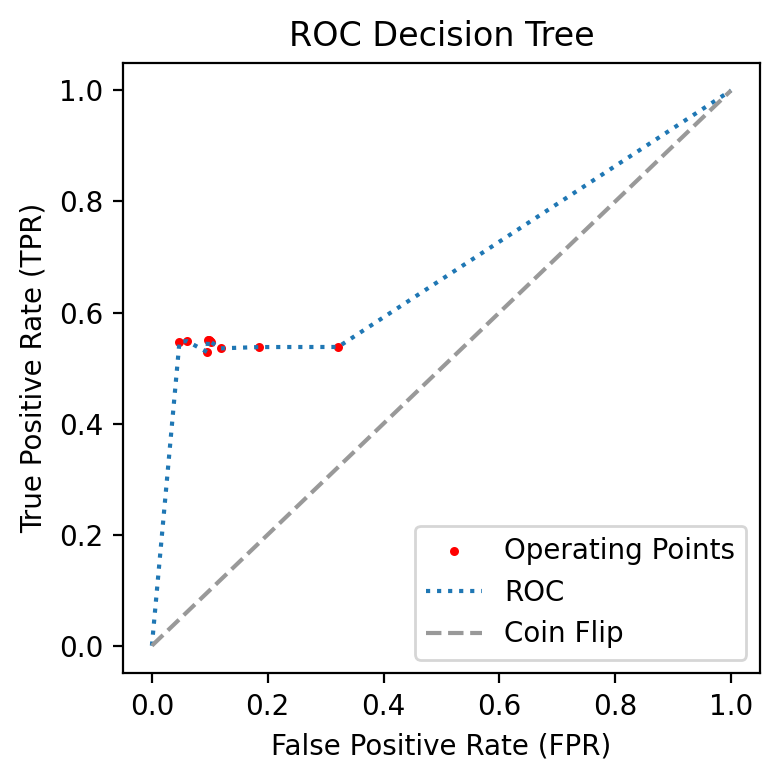

In [20]:
## DECISION TREE
acc, tpr, fpr = [], [], []
depth = (3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
n_feat = (3, 5, 7, 9, 11, 13, 15, 17, 19, 20)
for p in trange(hyperparameters):
    dtree = DecisionTreeClassifier(max_depth=depth[p], max_features=n_feat[p])
    a,t,f = train(dtree, X, y)
    acc.append(a); tpr.append(t); fpr.append(f)
print(f"Accuracy: {np.round(acc,2)}")
plot_ROC(tpr, fpr, title="ROC Decision Tree")

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Accuracy: [0.27 0.21 0.43 0.39 0.4  0.42 0.43 0.45 0.46 0.46]
[(0.32, 0.54), (0.49, 0.53), (0.32, 0.58), (0.42, 0.55), (0.41, 0.55), (0.4, 0.55), (0.4, 0.56), (0.39, 0.56), (0.38, 0.56), (0.38, 0.56)]


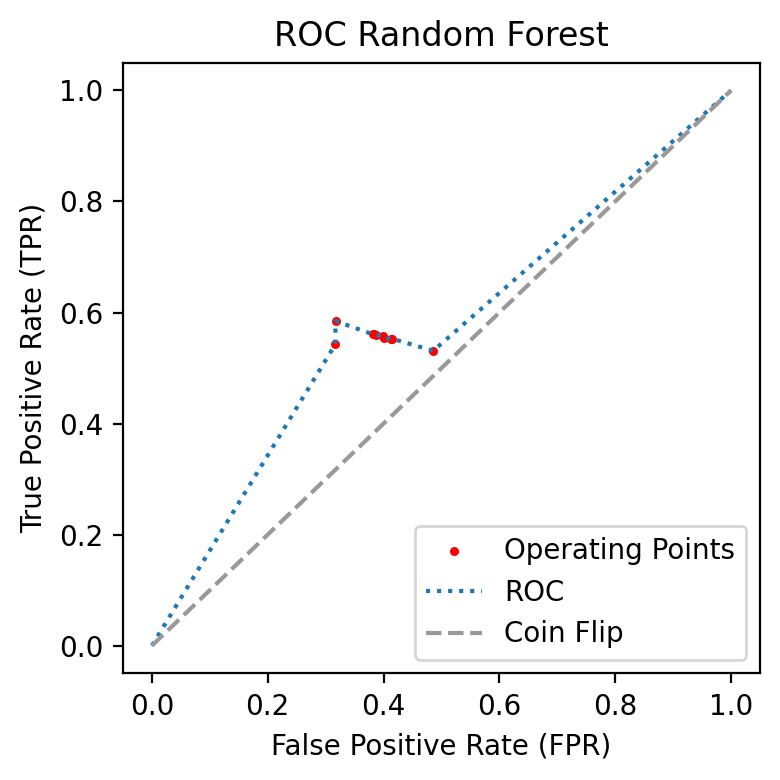

In [22]:
## RANDOM FOREST
acc, tpr, fpr = [], [], []
n_est = (1, 4, 8, 16, 32, 64, 70, 80, 90, 100)
for p in trange(hyperparameters):
    rf = RandomForestClassifier(n_estimators=n_est[p], max_depth=depth[p], max_features=n_feat[p])
    a,t,f = train(rf, X, y, k=3)
    acc.append(a); tpr.append(t); fpr.append(f)
print(f"Accuracy: {np.round(acc,2)}")
plot_ROC(tpr, fpr, title="ROC Random Forest")

  0%|          | 0/10 [00:00<?, ?it/s]/Users/brothag1/opt/anaconda3/envs/ed/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/brothag1/opt/anaconda3/envs/ed/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/brothag1/opt/anaconda3/envs/ed/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 10%|█         | 1/10 [00:04<00:42,  4.67s/it]/Users/brothag1/opt/anaconda3/envs/ed/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Accuracy: [0.47 0.55 0.52 0.52 0.52 0.54 0.52 0.52 0.52 0.54]
[(0.33, 0.58), (0.31, 0.57), (0.33, 0.57), (0.34, 0.57), (0.33, 0.57), (0.31, 0.57), (0.34, 0.57), (0.34, 0.57), (0.33, 0.57), (0.32, 0.57)]


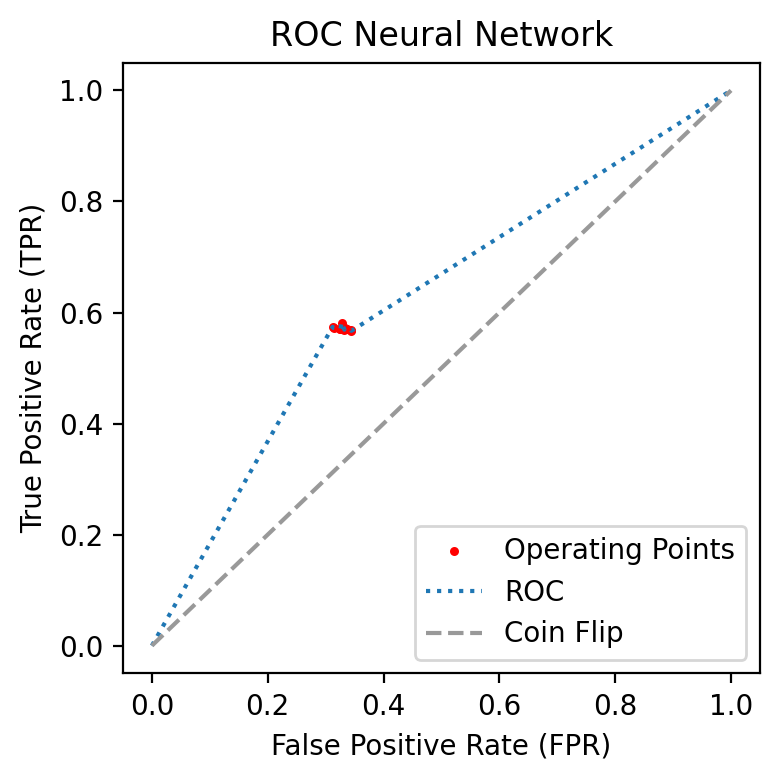

In [23]:
## NEURAL NETWORK
acc, tpr, fpr = [], [], []
h = (16, 32, 64, 96, 128, 160, 256, 310, 384, 512)
for p in trange(hyperparameters):
    # nn = MLPClassifier(hidden_layer_sizes=(h[p],), max_iter=100)
    nn = MLPClassifier(hidden_layer_sizes=[128]*p, max_iter=25)
    a,t,f = train(nn, X, y, k=3)
    acc.append(a); tpr.append(t); fpr.append(f)
print(f"Accuracy: {np.round(acc,2)}")
plot_ROC(tpr, fpr, title="ROC Neural Network")

2. [10 pts] What kind of behavior would you expect to see in Pd - Pf interaction of an ROC plot? Do you see it in yours? (Hint: Pd and Pf correspond to TPR and FPR.)  

I would expect a convex curve where the Pd increases sharply as Pf increases from 0 and then plateaus as Pf approaches 1. I see this slightly in the decision tree ROC, but not in the random forest or neural network ROCs. This is most likely because the hyperparameters I explored on this assignment did not sufficiently impact the true or false positive rates. I believe that if I had more familiarity with those models and this dataset, I might have a better intuition for the hyperparameters that would produce an interesting ROC curve. 

3. [10 pts] From the ROC plot that you created make a selection of the classifier and hyperparameter setting for this problem and then justify the selection. Note that we are classifying fake news so your conclusion might be subjective but has to be supported by your findings.   

NOTE: For the Random Forest and Neural Networks, I chose training and model parameters such that results would converge, as they ran prohibatively slowly on my computer with the initial parameters I looked at. I believe a much more in-depth study on a beefier computer would be warranted to find the best model parameters. 

Decision Tree
Since the ROC curve for the hyperparameters I chose is essentially flat, i.e. each OP has the same True Positive rate, I believe the sensible choice is to choose the lowest false positive rate. This gives us a decision tree with a depth of 4 and 5 features per split. 

Random Forest
One OP has the highest True positive rate (0.58) and the lowest False Positive Rate, making it an easy candidate. That point used a random forest with 8 estimators, a depth of 5 per estimator, and 7 features per split. 

Neural Network
My neural network model trained extremely slowly, so I wasn't able to play with the hyperparameters much and, as a result, all the points on the ROC curve are nearly identical. They nearly all have a True Positive rate of 0.57, so I will select the parameters with the lowest false positive rate of 0.31, giving us a network with 5 layers and 128 neurons per layer. 

4. [10 pts] Try adding text column to the features (again with Tf-Idf). Choose any classifier model to train on this new and improved dataset and report on its performance. Why do you think the performance is much higher than the previous one which only uses title column? 

Unique Text: 100.00%
Dropped 0 remaining text duplicates


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Accuracy: [0.6  0.7  0.72 0.82 0.89 0.88 0.94 0.97 0.97 0.98]
[(0.17, 0.56), (0.1, 0.6), (0.06, 0.55), (0.09, 0.58), (0.07, 0.56), (0.04, 0.57), (0.02, 0.6), (0.02, 0.6), (0.01, 0.58), (0.02, 0.59)]


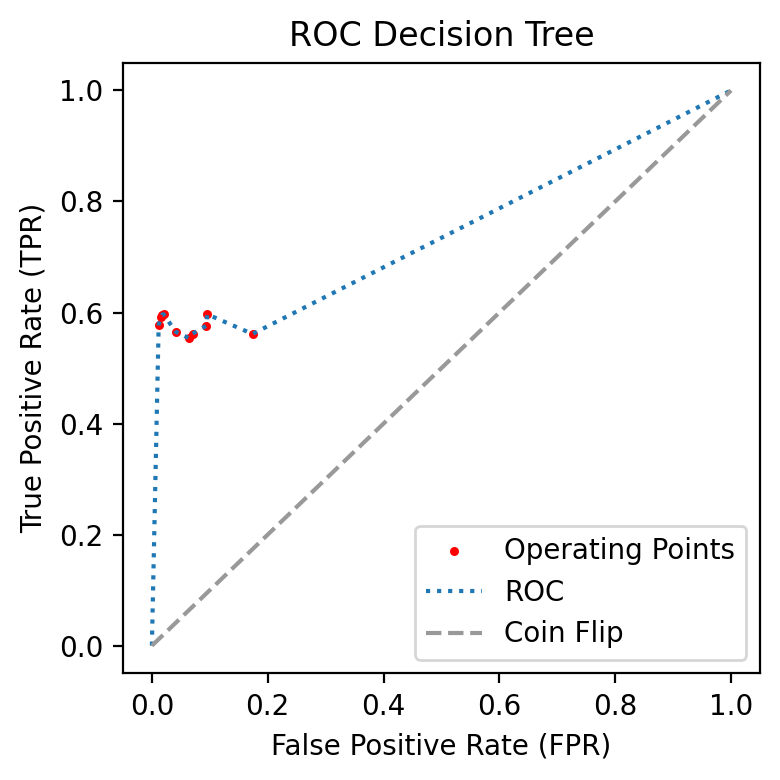

In [26]:
## PROBLEM 4
import scipy

## CLEANING
unique_text = 100 * df["text"].nunique() / df.title.count()
print(f"Unique Text: {unique_text:.2f}%")

## DROP TEXT DUPLICATES
df = df.drop_duplicates('text')
df.reset_index(inplace=True)
print(f"Dropped {n-len(df)} remaining text duplicates")
n = len(df)

X_text = TfidfVectorizer(stop_words='english', max_features=50).fit_transform(df['text'])
X_title = TfidfVectorizer(stop_words='english', max_features=50).fit_transform(df['title'])
X = scipy.sparse.csr_matrix(scipy.sparse.hstack((X_title, X_text)))
y = df["class"]

## DECISION TREE
acc, tpr, fpr = [], [], []
depth = (3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
n_feat = (3, 5, 7, 9, 11, 13, 15, 17, 19, 20)
for p in trange(hyperparameters):
    dtree = DecisionTreeClassifier(max_depth=depth[p], max_features=n_feat[p])
    a,t,f = train(dtree, X, y)
    acc.append(a); tpr.append(t); fpr.append(f)
print(f"Accuracy: {np.round(acc,2)}")
plot_ROC(tpr, fpr, title="ROC Decision Tree")

I chose to retrain the decision tree due to compute and time constraints. I believe the decision tree would benefit the least from this additional data as compared to the random forest or neural network. 

It performed a decent bit better than the original model, with all points seeing lower false positive rates and a slightly higher true positive rate for the best points. The best point had an 9% reduction in FPR and a 5% increase in TPR with the same set of hyperparameters that were optimal in the first setup -  depth of 4 and 5 features per split. 

I believe the primary cause is the fact that we include much more signal in each sample. The text captures much more information that the title, and the way in which an article is written may have much more useful signal for real-fake news discrimination than the title alone. In fact, fake news title's are probably designed to fool readers into thinking they are real. It is much easier to write a deceptive title than an entire body of text. 
